In [1]:
from osgeo import gdal
import fiona
import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio as rio

from nansat import Nansat
from nansat import *

from s1denoise import Sentinel1Image
from s1denoise import *

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.datasets import make_classification
from sklearn import preprocessing

import matplotlib as mpl

In [32]:
# Define path locations
s1_st_path = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210716T054037_20210716T054102_027815_0351B0_E546.zip'
s1_nt_path = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210707T171707_20210707T171732_027691_034E02_704A.zip'
s1_2015 = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20150728T170854_20150728T170919_007014_009866_9AF5.zip'
s1_nt_path_feb = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20210228T054121_20210228T054146_036786_045321_D2D0.zip'
s1_nt_path_march = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210309T171702_20210309T171727_025941_031822_64A6.zip'
s1_nt_path_april = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210426T171703_20210426T171728_026641_032E79_0FDD.zip'
s1_nt_path_may = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20210511T054123_20210511T054148_037836_047737_812E.zip'
s1_nt_path_june = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210625T171706_20210625T171731_027516_0348DE_41ED.zip'
s1_nt_path_july = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20210722T054127_20210722T054152_038886_0496AA_8C3D.zip'
s1_nt_path_aug = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210807T170858_20210807T170923_028143_035B7B_52BE.zip'
s1_nt_path_sep = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20210908T054130_20210908T054155_039586_04ADDC_EE10.zip'
s1_nt_path_oct = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20211017T171741_20211017T171806_040162_04C1B1_C588.zip'
s1_nt_path_nov = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20211116T171711_20211116T171736_029616_0388CC_3723.zip'
s1_nt_path_dec = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20211217T170849_20211217T170914_030068_039713_1E1E.zip'
s2_path = '/container_dir1/subsets/Subset_S2_20210716_resampled.tif'
src_awei = '/container_dir1/subsets/AWEI_S2B_MSIL2A_20210716.tif'
src_ndwi = '/container_dir1/subsets/NDWI_S2B_MSIL2A_20210716.tif'
src_vis = '/container_dir1/subsets/VIs_Subset_S2B_MSIL2A_20210716.tif'

In [76]:
# Open files
s1 = Nansat(s1_nt_path)

02:47:19|40|nansat|_get_dataset_metadata|GDAL could not open /container_dir1/subsets/S1B_IW_GRDH_1SDV_20210707T171707_20210707T171732_027691_034E02_704A.zip, trying to read with Nansat mappers...


In [4]:
# Open July image as base for classifier training, only once in the beginning
#s1_july = Nansat(s1_nt_path)

In [5]:
ndwi = Nansat(src_ndwi)
awei = Nansat(src_awei)
raw_bands_s2 = Nansat(s2_path)
vis = Nansat(src_vis)

In [77]:
#Reproject the S1 data to S2
s1r = s1
n = gdal.Open(s2_path)
d = Domain(ds=n)
s1r.reproject(d)

In [78]:
# Stack as multi-dimensional np array (or more first as list and then convert to array)
all_bands = [raw_bands_s2[band_n] for band_n in raw_bands_s2.bands().keys()]
all_bands.append(ndwi[1])
all_bands.append(awei[1])
for band_n in vis.bands().keys():
    all_bands.append(vis[band_n])

In [79]:
all_bands.append(s1r[8])

In [80]:
all_bands.append(s1r[10])

In [11]:
# Mike showing off his coding skills :D (and trying to speed up the code, but timewise it´s the same, I tested it)
#mike = np.zeros((15, 1091, 960))
#mike[0] = s1r[10]
#mike

In [81]:
bands_stack = np.array(all_bands)

# Check the shape of the array, should have 15 layers - 6 optical bands, 7 indices and 2 SAR-bands
bands_stack.shape

(15, 1091, 960)

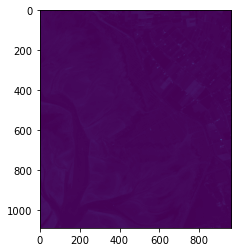

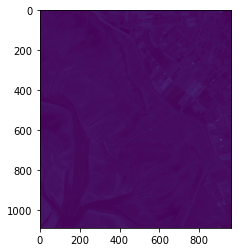

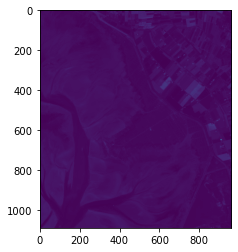

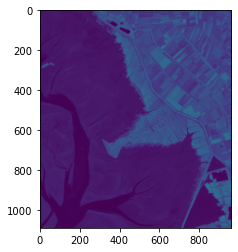

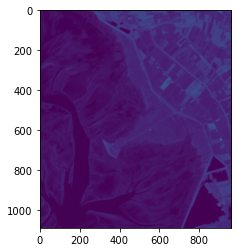

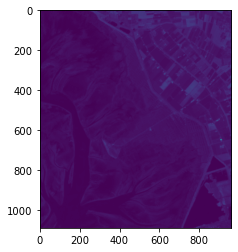

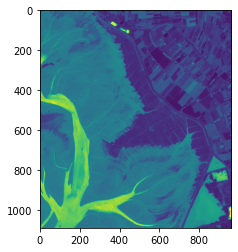

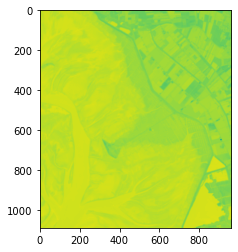

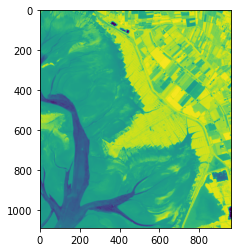

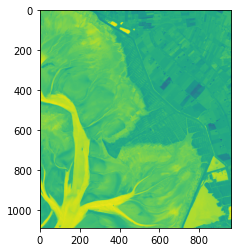

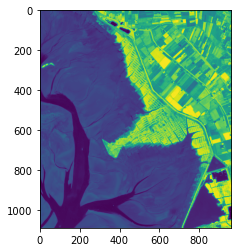

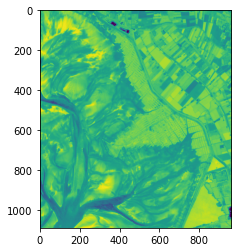

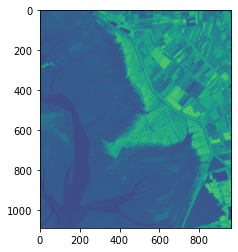

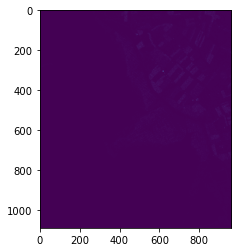

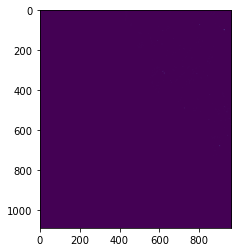

In [82]:
for i in range(bands_stack.shape[0]):
    plt.figure()
    plt.imshow(bands_stack[i, :, :])

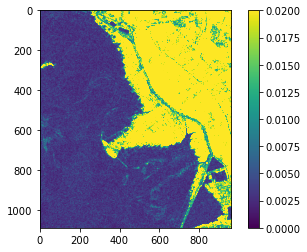

In [53]:
plt.imshow(s1r[8], vmin=0, vmax=0.02);plt.colorbar()

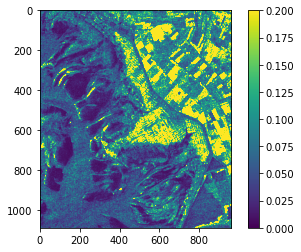

In [54]:
plt.imshow(s1r[10], vmin=0, vmax=0.2);plt.colorbar()

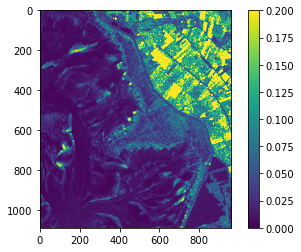

In [14]:
plt.imshow(bands_stack[14], vmin=0, vmax=0.2);plt.colorbar()

In [15]:
#VH = [s1r[8]]
#VV = [s1r[10]]
#type(VH)

#s1_stack = VH.append(VV)
#s1_stack_2 = np.array(VH)
#type(s1_stack_2)
#s1_stack_2 = np.stack((VH, VV))
#s1_stack_2.shape

In [16]:
#for i in range(s1_stack_2.shape[0]):
#    plt.figure()
#    plt.imshow(s1_stack_2[i, :, :])

In [83]:
## Export with Rasterio, because GDAL is a pain
with rio.open(src_vis) as src5:
    transform = src5.transform
    meta2 = src5.meta
affine = transform
crs = rio.crs.CRS.from_epsg(32632)

meta = {'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': bands_stack.shape[2],
 'height': bands_stack.shape[1],
 'count': bands_stack.shape[0],
 'crs': crs,
 'transform': affine}

with rio.open('/container_dir1/results/all_bands.tif', 'w', **meta) as dst:
    for band_nr, src in enumerate(bands_stack, start=1):
        dst.write_band(band_nr, src)

In [18]:
meta2
## dtype src_vis: float32
## dtype 

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 960,
 'height': 1091,
 'count': 5,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 484550.0,
        0.0, -10.0, 6057160.0)}

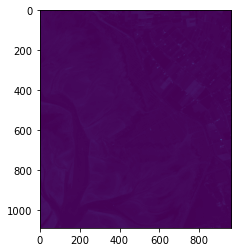

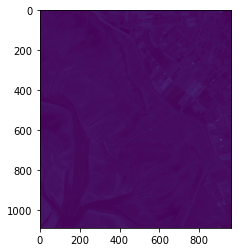

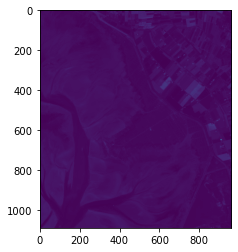

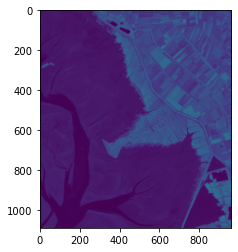

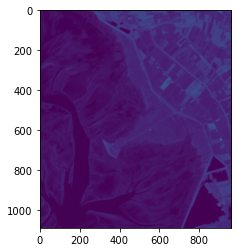

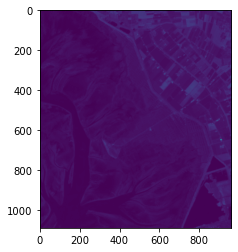

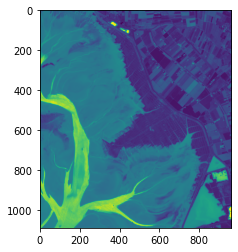

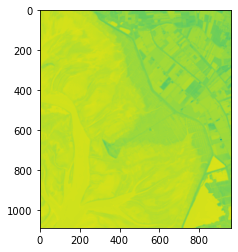

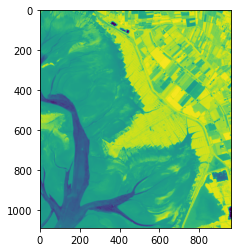

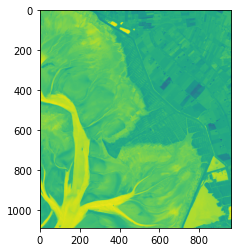

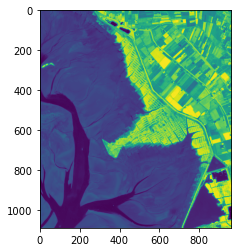

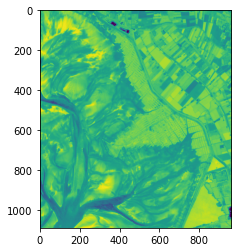

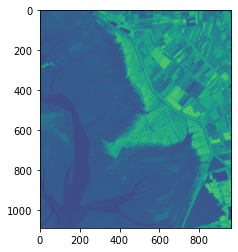

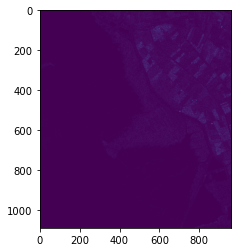

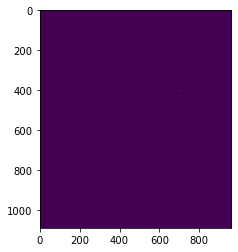

In [41]:
with rio.open('/container_dir1/results/all_bands.tif') as src1:
    img = src1.read()
for i in range(img.shape[0]):
    plt.figure()
    plt.imshow(img[i, :, :])

In [84]:
### Mask land with aoi shapefile
from rasterio.mask import mask

with fiona.open('/container_dir1/subsets/aoi.shp') as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rio.open('/container_dir1/results/all_bands.tif') as src4:
    out_image, transformed = mask(src4, shapes, crop=True, filled=True)
    out_meta = src4.meta

In [85]:
#Export masked stack
with rio.open('/container_dir1/results/all_bands_masked.tif', 'w', **out_meta) as dst:
    for band_nr, src in enumerate(out_image, start=1):
        dst.write_band(band_nr, src)

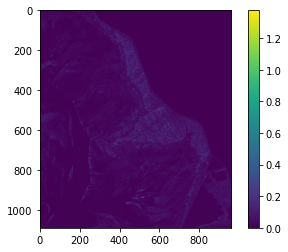

In [86]:
# Check if masking worked
with rio.open('/container_dir1/results/all_bands_masked.tif') as src:
    s1_stack = src.read()
#out_image.shape
plt.imshow(s1_stack[14]);plt.colorbar()

In [115]:
#Extract the pixel values of VIs & Bands at training points:
# Import shapefile table with labels
t_points_path = '/container_dir1/subsets/t_points_new2.shp'
points = gpd.read_file(t_points_path)
class_names = points['classtxt'].unique()
print(class_names)
points.head()

['water' 'structures' 'seabed' 'lsm' 'pioneer' 'usm']


,id,classid,classtxt,vertex_ind,vertex_par,vertex_p_1,distance,angle,x,y,geometry
0,None,1,water,0,0,0,0.000000,42.297056,8.784622,54.564908,POINT (486073.904 6046397.927)
1,None,1,water,1,0,1,9.984770,42.297056,8.784725,54.564975,POINT (486080.623 6046405.312)
2,None,1,water,2,0,2,19.969540,42.297056,8.784829,54.565041,POINT (486087.343 6046412.697)
3,None,1,water,3,0,3,29.954310,42.297056,8.784933,54.565108,POINT (486094.062 6046420.083)
4,None,1,water,4,0,4,39.939081,42.297056,8.785036,54.565175,POINT (486100.782 6046427.468)


In [116]:
### open the raster, sample/ extract values at training points
coord_list = [(x,y) for x,y in zip(points['geometry'].x , points['geometry'].y)]
with rio.open('/container_dir1/results/all_bands_masked.tif') as sava: 
    samplevalues = [x for x in sava.sample(coord_list)]

#B2 = [i[0] for i in samplevalues] 
#B3 = [i[1] for i in samplevalues]
#B4 = [i[2] for i in samplevalues]
#B8 = [i[3] for i in samplevalues]
#B11 = [i[4] for i in samplevalues]
#B12 = [i[5] for i in samplevalues]
#NDWI = [i[6] for i in samplevalues] 
#AWEI = [i[7] for i in samplevalues]
#NDVI = [i[8] for i in samplevalues] 
#SAVI = [i[9] for i in samplevalues]
#MSAVI = [i[10] for i in samplevalues] 
#NDMI = [i[11] for i in samplevalues]
#EVI = [i[12] for i in samplevalues] 
S0_VH = [i[13] for i in samplevalues]
S0_VV = [i[14] for i in samplevalues] 

#points['B2']=B2
#points['B3']=B3
#points['B4']=B4
#points['B8']=B8
#points['B11']=B11
#points['B12']=B12
#points['NDWI']=NDWI
#points['AWEI']=AWEI
#points['NDVI']=NDVI
#points['SAVI']=SAVI
#points['MSAVI']=MSAVI
#points['NDMI']=NDMI
#points['EVI']=EVI
points['S0_VH']=S0_VH
points['S0_VV']=S0_VV

points.columns
points.head()

,id,classid,classtxt,vertex_ind,vertex_par,vertex_p_1,distance,angle,x,y,geometry,S0_VH,S0_VV
0,None,1,water,0,0,0,0.000000,42.297056,8.784622,54.564908,POINT (486073.904 6046397.927),0.003226,0.005825
1,None,1,water,1,0,1,9.984770,42.297056,8.784725,54.564975,POINT (486080.623 6046405.312),0.002130,0.003027
2,None,1,water,2,0,2,19.969540,42.297056,8.784829,54.565041,POINT (486087.343 6046412.697),0.001969,0.004083
3,None,1,water,3,0,3,29.954310,42.297056,8.784933,54.565108,POINT (486094.062 6046420.083),0.002297,0.005557
4,None,1,water,4,0,4,39.939081,42.297056,8.785036,54.565175,POINT (486100.782 6046427.468),0.001667,0.005040


In [117]:
# create new working gdf with only the interesting columns and without the qgis stuff in original table
#points2 = points[['classid', 'classtxt', 'geometry', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDWI', 'AWEI', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'S0_VH', 'S0_VV']].copy()
points2 = points[['classid', 'classtxt', 'geometry', 'S0_VH', 'S0_VV']].copy()
points2

### Problem: decimals don´t get imported.... -.-
### Problem solved: changed dtype in meta data when exporting the raster stack to float

,classid,classtxt,geometry,S0_VH,S0_VV
0,1,water,POINT (486073.904 6046397.927),0.003226,0.005825
1,1,water,POINT (486080.623 6046405.312),0.002130,0.003027
2,1,water,POINT (486087.343 6046412.697),0.001969,0.004083
3,1,water,POINT (486094.062 6046420.083),0.002297,0.005557
4,1,water,POINT (486100.782 6046427.468),0.001667,0.005040
...,...,...,...,...,...
14140,5,lsm,POINT (489238.936 6051398.693),0.013770,0.025605
14141,5,lsm,POINT (489231.804 6051405.338),0.007283,0.020231
14142,5,lsm,POINT (489224.672 6051411.984),0.004328,0.020740
14143,5,lsm,POINT (489217.540 6051418.630),0.005845,0.073998


In [26]:
### Export geodataframe as trainingpoints for classification
#points2.to_file('/container_dir1/results/gdf_train_pixelvalues.shp', mode='w')

In [118]:
points2.columns

Index(['classid', 'classtxt', 'geometry', 'S0_VH', 'S0_VV'], dtype='object')

In [121]:
# Drop classes seabed and structures for now, because we only want a binary classification AND the tides of S1 and S2 do not go together - so drop 
# pioneer saltmarsh as well, because this is water in S1 and vegetation in S2/VIs...
#points2 = points2[(points2.classtxt != 'seabed') & (points2.classtxt != 'structures') & (points2.classtxt != 'pioneer')]

In [122]:
class_names2 = points2['classid'].unique()
print(class_names2)

[0 1]


In [120]:
points2.loc[points2['classid'] == 1, ['classid']] = 0
points2.loc[points2['classid'] == 2, ['classid']] = 0
points2.loc[points2['classid'] == 3, ['classid']] = 0
points2.loc[points2['classid'] == 4, ['classid']] = 1
points2.loc[points2['classid'] == 5, ['classid']] = 1
points2.loc[points2['classid'] == 6, ['classid']] = 1

In [121]:
points2.head()

,classid,classtxt,geometry,S0_VH,S0_VV
0,0,water,POINT (486073.904 6046397.927),0.003226,0.005825
1,0,water,POINT (486080.623 6046405.312),0.002130,0.003027
2,0,water,POINT (486087.343 6046412.697),0.001969,0.004083
3,0,water,POINT (486094.062 6046420.083),0.002297,0.005557
4,0,water,POINT (486100.782 6046427.468),0.001667,0.005040


In [123]:
# Start splitting training points into train and test data set
# Convert points2 to a normal pandas dataframe, because there is a np array somewhere in there and it causes problems
df = pd.DataFrame(points2)
#cols = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDWI', 'AWEI', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'S0_VH', 'S0_VV']
cols = ['S0_VH', 'S0_VV']
X_train, X_test, y_train, y_test=train_test_split(df[cols], df['classid'], train_size=0.7, random_state=42)
X_train
print(y_train)

4053     0
12242    0
108      0
6264     0
9552     1
        ..
5191     0
13418    1
5390     0
860      0
7270     0
Name: classid, Length: 9901, dtype: int64


In [124]:
y = points2['classid']
y.value_counts()

0    10185
1     3960
Name: classid, dtype: int64

In [158]:
### Normal classification without scaling, fitting the classifier
clf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=50) # class_weight = {0:1,1:2})
clf.fit(X_train, y_train)
#print(clf.score())

RandomForestClassifier(class_weight={0: 1, 1: 2}, n_jobs=-1, random_state=50)

In [159]:
clf_classified = clf.predict(X_test)
#clf_classified = (clf.predict_proba(X_test)[:,1] >= 0.8).astype(bool)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


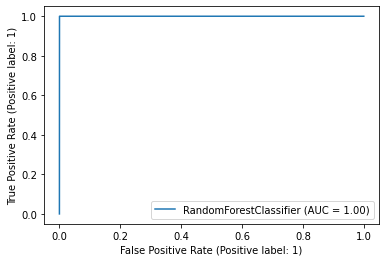

In [144]:
from sklearn.metrics import roc_curve,plot_roc_curve, balanced_accuracy_score
plot_roc_curve(clf,X_train,y_train)

In [145]:
fpr, tpr, thresholds = roc_curve(y_train,clf.predict_proba(X_train)[:,1],drop_intermediate=False)

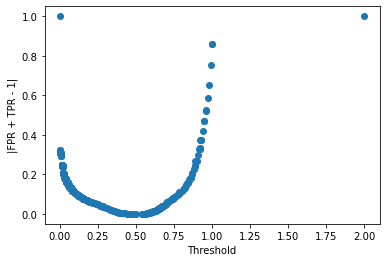

In [146]:
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [147]:
thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.54

In [148]:
threshold = []
accuracy = []

for p in np.unique(clf.predict_proba(X_train)[:,1]):
    threshold.append(p)
    y_pred = (clf.predict_proba(X_train)[:,1] >= p).astype(int)
    accuracy.append(balanced_accuracy_score(y_train,y_pred))

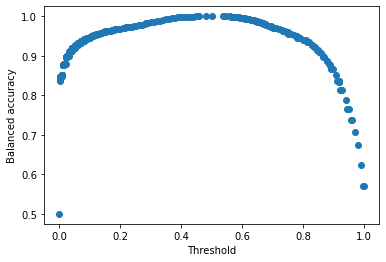

In [149]:
plt.scatter(threshold,accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

In [150]:
threshold[np.argmax(accuracy)]

0.5372184627815372

[0 1 0 ... 0 0 0]


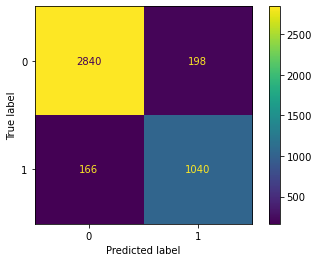

,0,1,accuracy,macro avg,weighted avg
precision,0.944777,0.840065,0.914232,0.892421,0.915021
recall,0.934826,0.862355,0.914232,0.898590,0.914232
f1-score,0.939775,0.851064,0.914232,0.895419,0.914566
support,3038.000000,1206.000000,0.914232,4244.000000,4244.000000


In [160]:
### Accuracy scores
#scores = cross_val_score(clf, X_test, y_train.values, cv=5)
#scores

#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# classification = clf_classified.reshape((rows, cols))

print(clf_classified)
#build confusion matrix (x-axis: predicted pixels, y-axis: reference pixels; class 1,2,3,4,5)
cm = confusion_matrix(y_test.values, clf_classified, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = clf.classes_)
disp.plot()
plt.show()

from sklearn.metrics import classification_report

#calculate number of pixels that were classified correctly
accuracy_score(y_test, clf_classified, normalize=True)
pd.DataFrame(classification_report(y_test, clf_classified, digits=2, output_dict=True))

In [161]:
### Save the model

joblib.dump(clf, '/container_dir1/results/RFC_classw_S1.joblib')
#loaded_clf = joblib.load('/container_dir1/results/RFC_all_data.joblib')
loaded_clf = joblib.load('/container_dir1/results/RFC_classw_S1.joblib')

# loaded_clf.predict(X_test)
#loaded_clf.predict(X_test)

In [30]:
clf_classified

array([1, 6, 1, ..., 1, 1, 1])

In [31]:
out_image.shape

(15, 1091, 960)

In [32]:
clf_classified.shape
#should have same [0] shape value as X_test

(4244,)

In [33]:
X_test.shape

(4244, 2)

In [162]:
with rio.open('/container_dir1/results/all_bands_masked.tif') as src5:
    meta = src5.meta
    arr = src5.read()

In [163]:
### Apply to more original stack
#keys = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDWI', 'AWEI', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'S0_VH', 'S0_VV']
keys = ['S0_VH', 'S0_VV']
arr_flat = [arr[i, :, :].flatten() for i in range(arr.shape[0])]
# returns a list instead of a flattened array?????

In [68]:
arr.shape
# should be 15, 1091, 960)

(15, 1091, 960)

In [164]:
# Create a Dataframe for RF prediction
raster_df = pd.DataFrame({
    "S0_VH" : arr_flat[13],
    "S0_VV" : arr_flat[14]})

In [30]:
#raster_df = pd.DataFrame({
#   "B2" : arr_flat[0],
#    "B3" : arr_flat[1],
#    "B4" : arr_flat[2],
#    "B8" : arr_flat[3],
#    "B11" : arr_flat[4],
#    "B12" : arr_flat[5],
#    "NDWI" : arr_flat[6],
#    "AWEI" : arr_flat[7],
#    "NDVI" : arr_flat[8],
#    "SAVI" : arr_flat[9],
#    "MSAVI" : arr_flat[10],
#    "NDMI" : arr_flat[11],
#    "EVI" : arr_flat[12],
#    "S0_VH" : arr_flat[13],
#    "S0_VV" : arr_flat[14]})

In [104]:
cols_raster_df = raster_df.columns

#show length of raster data frame to check number
len(raster_df.columns)
# should be 15/2/etc. ... and 1047360 rows 

2

In [165]:
#show if it worked and all the column-names are correct and in the correct order in the raster data frame
raster_df
#why is it all 0 for the bands as well? is that correct?

,S0_VH,S0_VV
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
1047355,0.0,0.0
1047356,0.0,0.0
1047357,0.0,0.0
1047358,0.0,0.0


In [166]:
#classify the raster
raster_pred = loaded_clf.predict(raster_df)
#reshape from array to raster
#take shape from original raster
shape_out = (arr.shape[1], arr.shape[2])
print(shape_out)
#show shape from original raster: 2-dimensional (correct? multidimensional?)
shape_out

#final classified raster is reshaped as the original --> multidimensional
raster_out = raster_pred.reshape(shape_out)
print(raster_out.shape)

### Output path
#output = '/container_dir1/results/RFC_S1_2015_july.tif'

#define output data type (same as original)
#meta["dtype"] = 'float32'
#meta["count"] = 1

#test if it worked
#meta
#with rio.open(output, 'w', **meta) as dst:
#    dst.write(raster_out, 1)
    
raster_out

(1091, 960)
(1091, 960)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [107]:
raster_pred

array([1, 1, 1, ..., 1, 1, 1])

(array([877177.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 170183.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

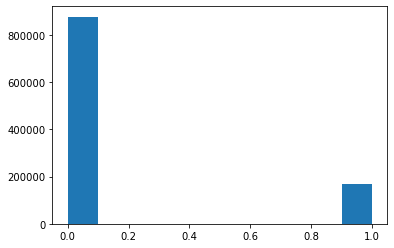

In [167]:
plt.hist(raster_pred)
#plt.savefig('hist_jul_2021.png')

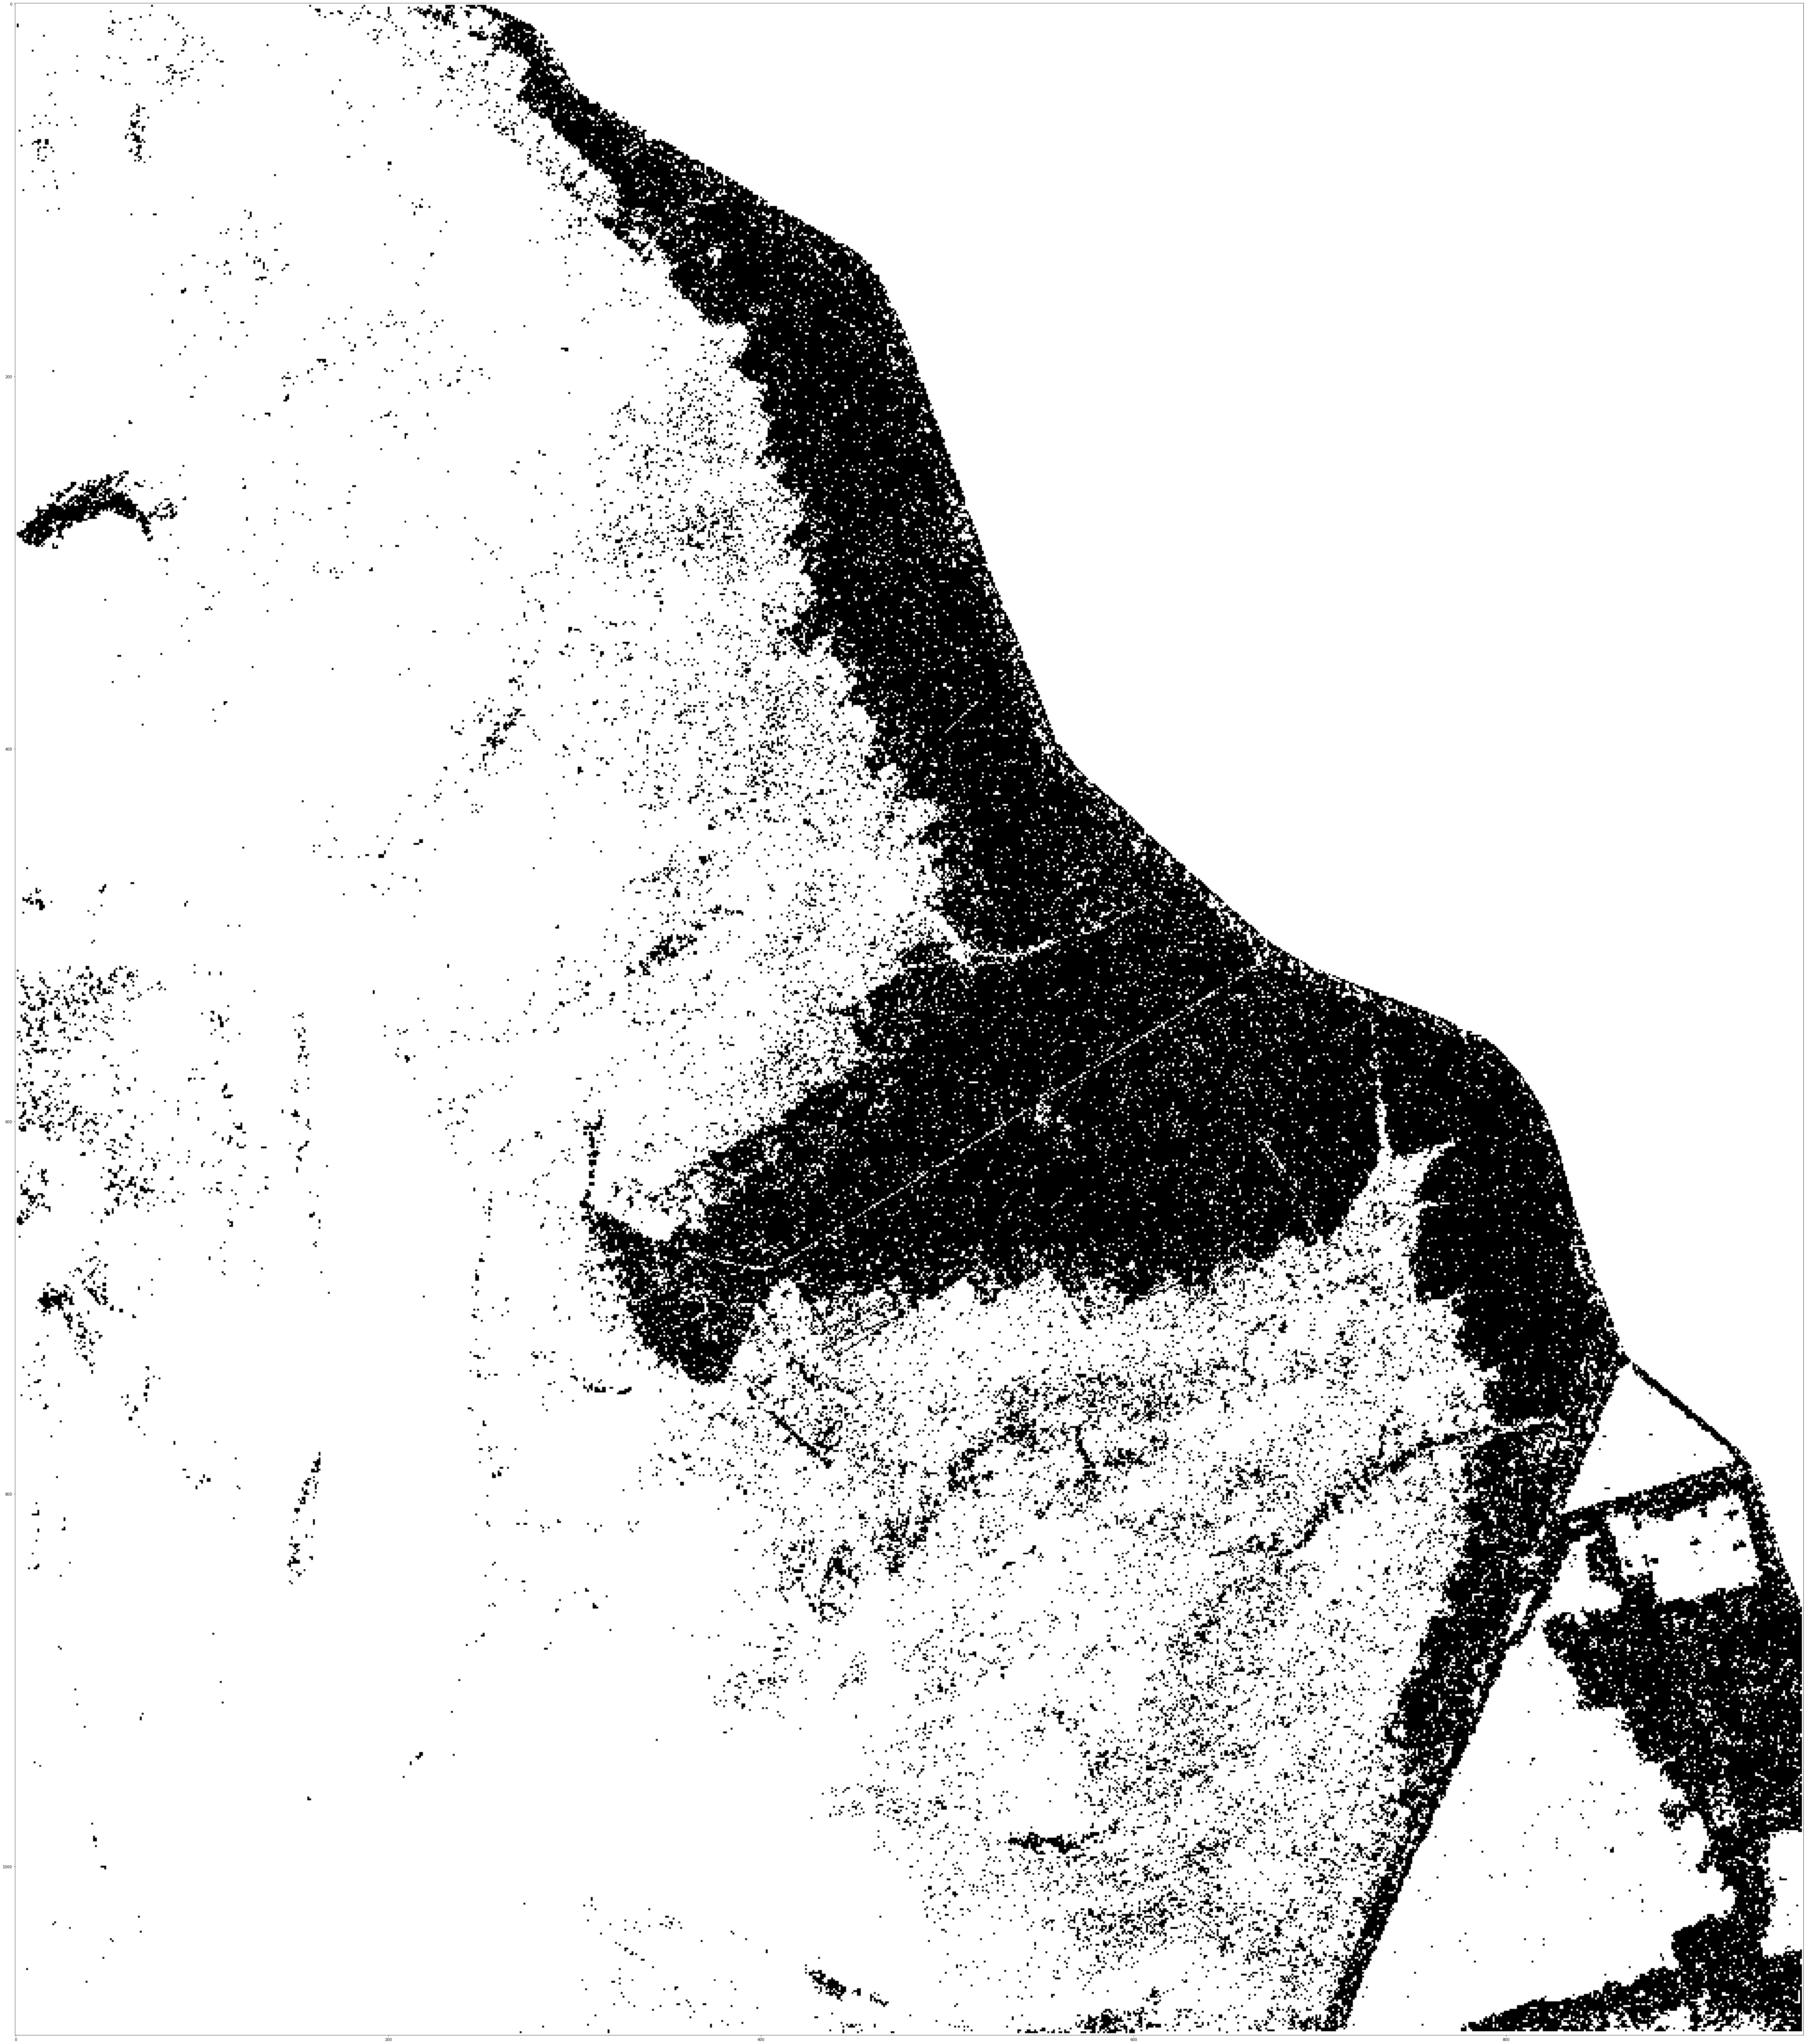

In [168]:
# Plot and save the classification 
fig = plt.figure(figsize=(100,100))  
fig.add_subplot(1, 1, 1)
plt.imshow(raster_out, cmap='binary')
#plt.title('Random Forest Classification S1 July 2021'); plt.colorbar()
plt.savefig('rfc_S1_cw_2021_july_big.png')

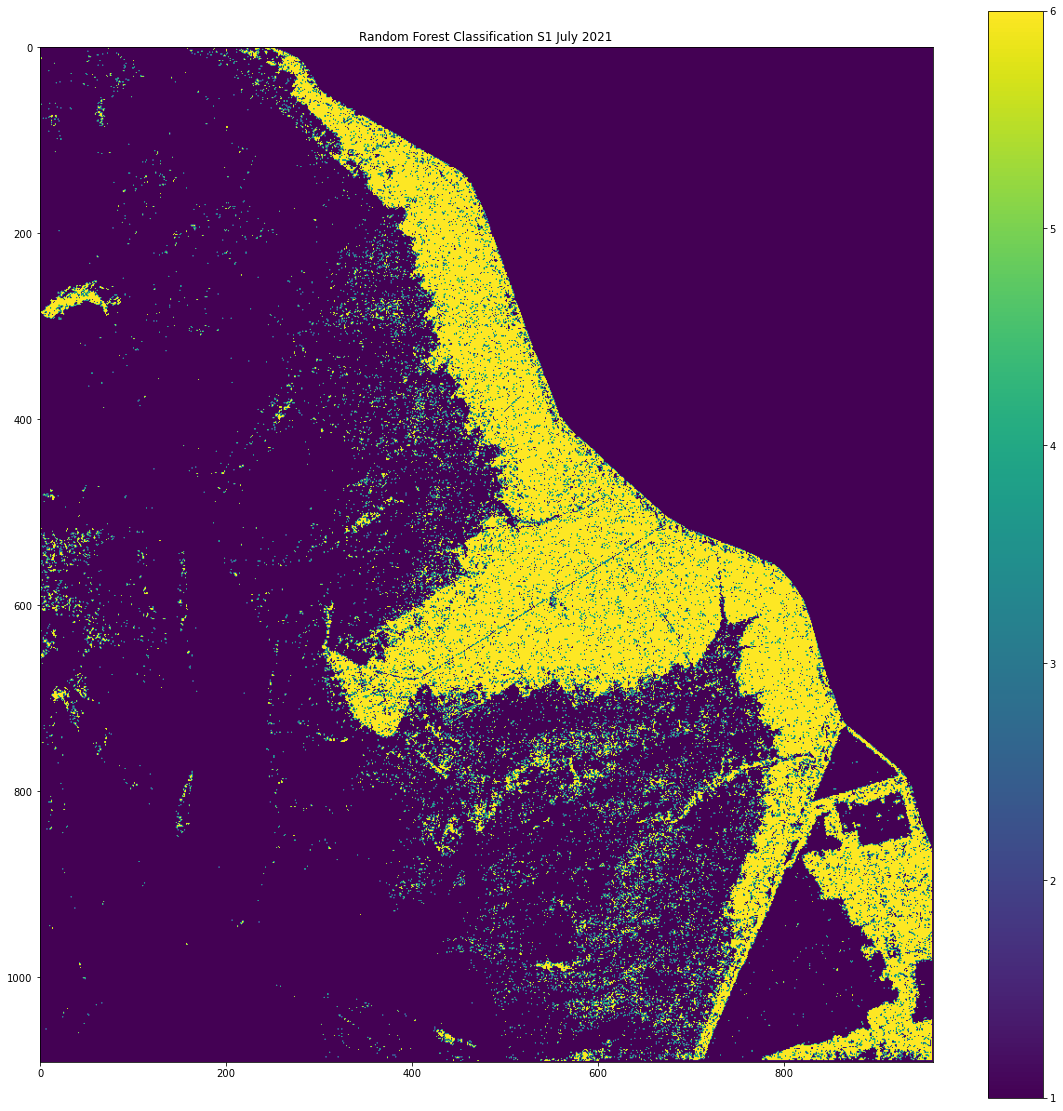

In [113]:
# Plot and save the classification 
fig = plt.figure(figsize=(20,20))  
fig.add_subplot(1, 1, 1)
plt.imshow(raster_out)
plt.title('Random Forest Classification S1 July 2021'); plt.colorbar()
plt.savefig('rfc_S1_binary_2021_july_small.png')